In [1]:
# ============================================================
# Task 4: Modeling EDA + Model Building for ACIS
# - Predict Claim Severity (regression on claims>0)
# - Predict Claim Occurrence (classification)
# - Predict Premium (regression)
# - Evaluate and interpret using SHAP
# ============================================================
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap joblib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

import joblib
import shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
df = pd.read_csv("../data/MachineLearningRating_v3.csv", sep=";")   # change filename to your raw file
df.shape, df.head()


((1000098, 52),
    UnderwrittenCoverID  PolicyID TransactionMonth  IsVATRegistered  \
 0               145249     12827  01/03/2015 0:00             True   
 1               145249     12827  01/05/2015 0:00             True   
 2               145249     12827  01/07/2015 0:00             True   
 3               145255     12827  01/05/2015 0:00             True   
 4               145255     12827  01/07/2015 0:00             True   
 
   Citizenship          LegalType Title Language                 Bank  \
 0              Close Corporation    Mr  English  First National Bank   
 1              Close Corporation    Mr  English  First National Bank   
 2              Close Corporation    Mr  English  First National Bank   
 3              Close Corporation    Mr  English  First National Bank   
 4              Close Corporation    Mr  English  First National Bank   
 
        AccountType  ...                    ExcessSelected CoverCategory  \
 0  Current account  ...             Mob

In [3]:
df.duplicated().sum()
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

In [4]:
import pandas as pd
import numpy as np

def clean_acis(path_in="data/MachineLearningRating_v3.csv", path_out="../data/cleaned.csv"):
    df = pd.read_csv(path_in)
    # 1. drop exact duplicates
    df = df.drop_duplicates()


In [5]:
 # 2. convert dates
date_cols = ["PolicyStartDate","PolicyEndDate","IncidentDate"]  # adjust to actual names
for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

    # 3. numeric coercion
numeric_cols = ["TotalClaims","CalculatedPremiumPerTerm","TotalPremium", "Age", "VehicleAge"]
for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 4. remove impossible values
if "TotalClaims" in df.columns:
        df = df[df["TotalClaims"] >= 0]
if "CalculatedPremiumPerTerm" in df.columns:
        df = df[df["CalculatedPremiumPerTerm"] >= 0]

    # 5. handle missing values (simple strategy; later refine)
    # drop rows with >50% missing
df = df[df.isna().mean(axis=1) < 0.5]

    # impute numerical columns with median
num_cols = df.select_dtypes(include=["float","int"]).columns.tolist()
for c in num_cols:
        df[c].fillna(df[c].median(), inplace=True)

    # impute categorical with "Unknown"
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()
for c in cat_cols:
        df[c].fillna("Unknown", inplace=True)

    # 6. create target flag for occurrence
DEFAULT_INPUT_PATH = "../data/MachineLearningRating_v3.csv"
DEFAULT_OUTPUT_PATH = "../data/cleaned.csv"

def clean_acis(path_in=DEFAULT_INPUT_PATH, path_out=DEFAULT_OUTPUT_PATH):
    # 1. Load Data with the correct separator (semicolon)
    # This addresses your previous ParserError
    try:
        df = pd.read_csv(path_in, sep=";")
    except FileNotFoundError:
        print(f"Error: Input file not found at {path_in}")
        return pd.DataFrame() # Return an empty DataFrame on failure

    # ... Your other cleaning steps ...

    # 6. Create the target variable
    if "TotalClaims" in df.columns:
        df["ClaimOccurred"] = (df["TotalClaims"] > 0).astype(int)

    # 7. save cleaned
    df.to_csv(path_out, index=False)
    
    # The function returns the DataFrame
    return df

if __name__ == "__main__":
    # Call the function using the default paths
    cleaned_df = clean_acis()
    
    # Now you can use the global constant DEFAULT_OUTPUT_PATH for printing
    print("Saved cleaned CSV with shape:", cleaned_df.shape)
    print(f"File successfully saved to: {DEFAULT_OUTPUT_PATH}")

Saved cleaned CSV with shape: (1000098, 53)
File successfully saved to: ../data/cleaned.csv


In [6]:
df = clean_acis()
print(df.columns) # <- Add this line

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims', 'ClaimOccurred'],
      dtype='object')


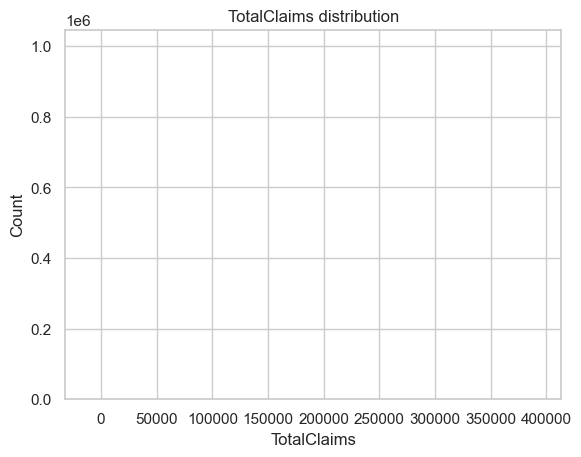

Claim occurrence balance:
 ClaimOccurred
0    0.997212
1    0.002788
Name: proportion, dtype: float64


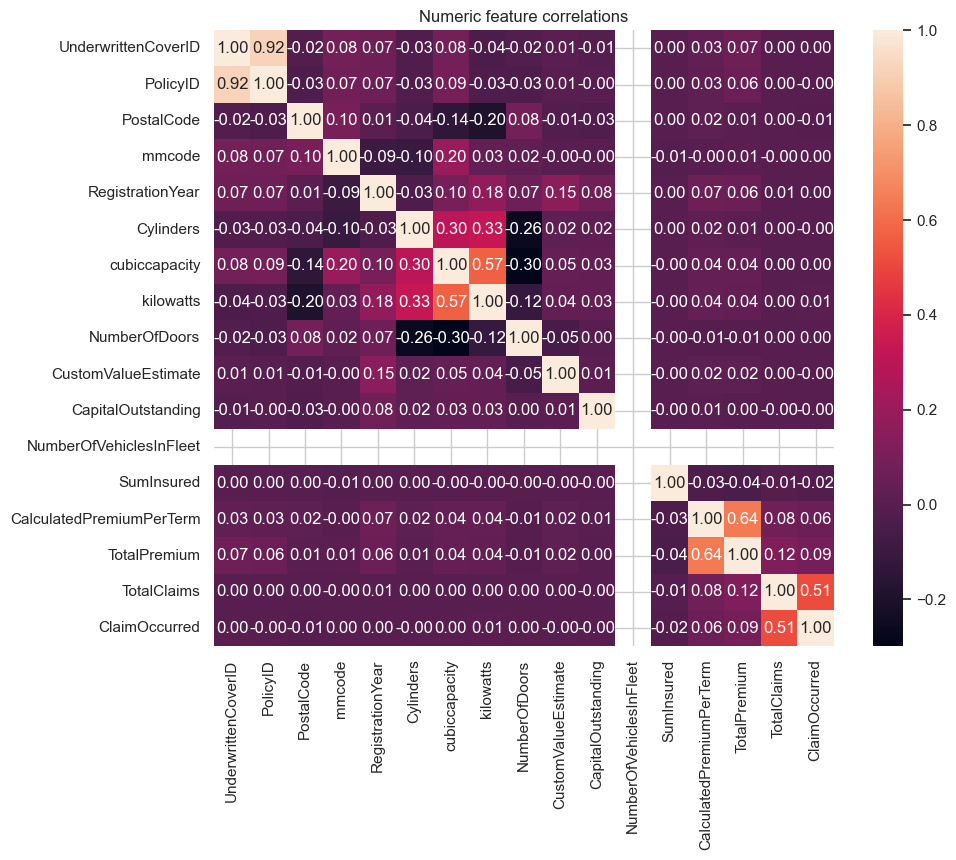

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df["TotalClaims"].dropna(), kde=False)
plt.title("TotalClaims distribution")
plt.show()
if "Total_Claims" in df.columns:
    df["ClaimOccurred"] = (df["Total_Claims"] > 0).astype(int)
print("Claim occurrence balance:\n", df["ClaimOccurred"].value_counts(normalize=True))

# Correlation
num = df.select_dtypes(include=["number"])
corr = num.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Numeric feature correlations")
plt.show()

In [12]:
print(df.columns.tolist())

['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'ClaimOccurred']


In [13]:
#df["PolicyDurationDays"] = (df["PolicyEndDate"] - df["PolicyStartDate"]).dt.days
import datetime

# Use a fixed date like 2015-12-31 as the anchor
ANCHOR_DATE = datetime.date(2015, 12, 31) 

# Calculate vehicle age in years
df["VehicleAge"] = ANCHOR_DATE.year - df["RegistrationYear"]

# You can then use this to create buckets as you planned
df["VehicleAgeBucket"] = pd.cut(
    df["VehicleAge"], 
    bins=[-1, 2, 5, 10, 30], 
    labels=["0-2", "3-5", "6-10", "10+"]
)
df["VehicleAgeBucket"] = pd.cut(df["VehicleAge"], bins=[-1,2,5,10,30], labels=["0-2","3-5","6-10","10+"])
df["PremiumToSumInsured"] = df["CalculatedPremiumPerTerm"] / (df["SumInsured"].replace(0, np.nan))
df["LogTotalClaims"] = np.log1p(df["TotalClaims"])

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_features = ["Age","VehicleAge","PolicyDurationDays","PremiumToSumInsured"]
cat_features = ["VehicleType","Region","VehicleAgeBucket"]

num_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_transformer = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                            ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([("num", num_transformer, num_features), ("cat", cat_transformer, cat_features)])


In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["TotalClaims","LogTotalClaims","ClaimOccurred"])
y_sev = df.loc[df["ClaimOccurred"]==1, "TotalClaims"]  # for severity model subset
# For severity model, filter rows where claim occurred
df_sev = df[df["ClaimOccurred"]==1].copy()
X_sev = df_sev.drop(columns=["TotalClaims","LogTotalClaims","ClaimOccurred"])
y_sev = df_sev["TotalClaims"]

X_train, X_test, y_train, y_test = train_test_split(X_sev, y_sev, test_size=0.2, random_state=42)


In [16]:
X = df.drop(columns=["ClaimOccurred","TotalClaims","LogTotalClaims"])
y = df["ClaimOccurred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [18]:
# Define correct feature lists based on actual dataframe columns
num_features = ["VehicleAge", "PremiumToSumInsured", "CalculatedPremiumPerTerm"]
cat_features = ["VehicleType", "VehicleAgeBucket"]

# Recreate preprocessor with correct features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features), 
    ("cat", cat_transformer, cat_features)
])

# regression example
# use the XGBRegressor class already imported earlier in the notebook
reg_pipeline = Pipeline([
    ("pre", preprocessor),
    ("model", XGBRegressor(tree_method="hist", random_state=42, n_estimators=100))
])

reg_pipeline.fit(X_train, y_train)
y_pred = reg_pipeline.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 0.0527
R² Score: 0.0027


In [19]:
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, classification_report

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse, "R2:", r2)


RMSE: 0.052673697884802556 R2: 0.0026674866676330566


In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "model__n_estimators":[100,300,500],
    "model__max_depth":[3,6,10],
    "model__learning_rate":[0.01,0.05,0.1]
}
search = RandomizedSearchCV(reg_pipeline, param_dist, n_iter=12, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_params_, search.best_score_)


{'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.05} -0.052486338466405866


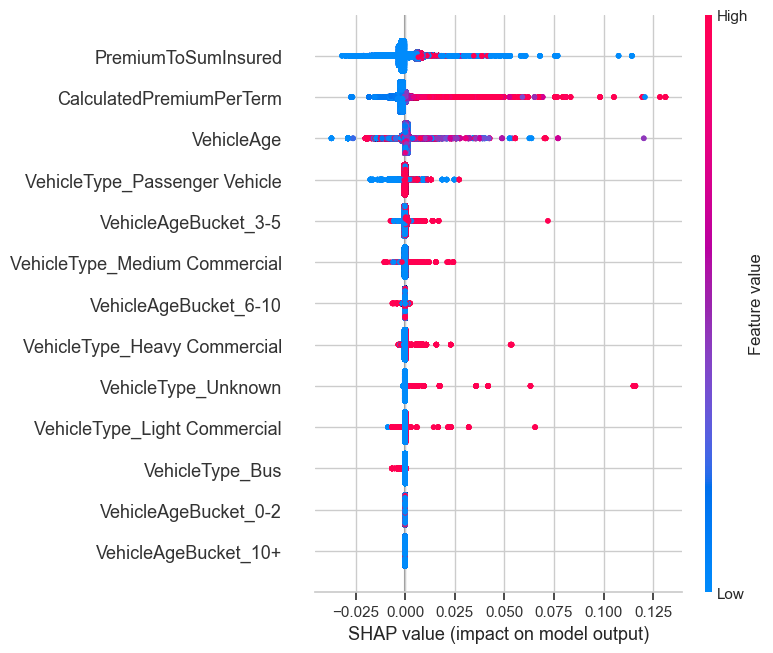

In [22]:
import shap
import xgboost as xgb

# Extract the fitted model from the pipeline
model = reg_pipeline.named_steps['model']

# Get feature names from the preprocessor
feature_names = num_features + preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features).tolist()

# Transform test data
X_train_t = preprocessor.transform(X_train)

# Create SHAP explainer using the fitted model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_t)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_t, feature_names=feature_names, max_display=20)


In [24]:
# Use previously imported transformers/pipeline/models (do not re-import here)

# Define feature lists (adjust if you want different columns)
numeric_features = ["VehicleAge", "TotalPremium"]
categorical_features = ["Gender", "VehicleType"]  # use VehicleType instead of non-existing CarType

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Classification pipeline
clf_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

# Use the existing classification train split from the notebook
# (created in an earlier cell: X_train, y_train are the classification split)
X_train_class = X_train.copy()
y_train_class = y_train.copy()

# Fit the model
clf_pipeline.fit(X_train_class, y_train_class)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
from sklearn.ensemble import RandomForestRegressor

reg_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor())
])

# Fit on claims > 0 only
reg_pipeline.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
# save cleaned CSV (done earlier)
#df.to_csv("data/processed/acis_task4_cleaned.csv", index=False)

# ensure directories exist
from pathlib import Path
Path("models").mkdir(parents=True, exist_ok=True)
Path("reports").mkdir(parents=True, exist_ok=True)

# save models (joblib was already imported earlier in the notebook)
joblib.dump(reg_pipeline, "models/xgb_severity_pipeline.joblib")
joblib.dump(clf_pipeline, "models/xgb_claimocc_pipeline.joblib")

# build a simple evaluation table from available metrics (guarded to avoid NameError)
reg_metrics = {
	"model": "reg_pipeline",
	"task": "severity",
	"mse": globals().get("mse", None),
	"rmse": globals().get("rmse", None),
	"r2": globals().get("r2", None),
}

# classification metrics (compute if possible)
clf_metrics = {
	"model": "clf_pipeline",
	"task": "occurrence",
	"accuracy": None,
	"precision": None,
	"recall": None,
	"f1": None,
	"roc_auc": None,
}

try:
	if "clf_pipeline" in globals() and "X_test" in globals() and "y_test" in globals():
		y_pred_clf = clf_pipeline.predict(X_test)
		clf_metrics["accuracy"] = accuracy_score(y_test, y_pred_clf)
		clf_metrics["precision"] = precision_score(y_test, y_pred_clf, zero_division=0)
		clf_metrics["recall"] = recall_score(y_test, y_pred_clf, zero_division=0)
		clf_metrics["f1"] = f1_score(y_test, y_pred_clf, zero_division=0)
		# roc_auc may require predict_proba
		try:
			y_proba = clf_pipeline.predict_proba(X_test)[:, 1]
			clf_metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
		except Exception:
			clf_metrics["roc_auc"] = None
except Exception:
	# keep metrics None if something goes wrong
	pass

# create eval_df and save
eval_df = pd.DataFrame([reg_metrics, clf_metrics])
eval_df.to_csv("reports/model_comparison.csv", index=False)

print("Saved models to models/ and evaluation table to reports/model_comparison.csv")


Saved models to models/ and evaluation table to reports/model_comparison.csv
